In [1]:
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import numpy as np

<AxesSubplot:xlabel='label', ylabel='count'>

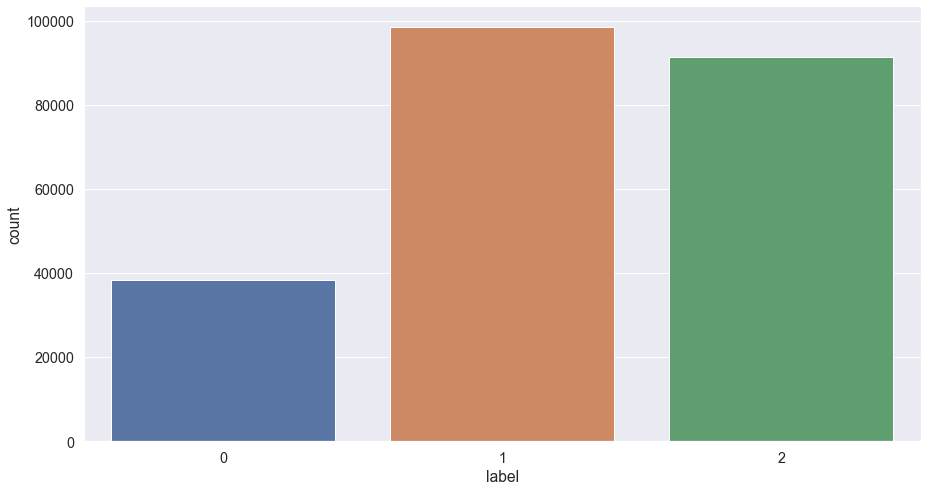

In [4]:
# 데이터 불러오기
financial_data = pd.read_csv("./stock_data_textsummarization_2/stock_data_textsummarization_2/반도체와반도체장비_지수.csv", encoding='utf-8', index_col=0)
financial_data = financial_data[['content','label']]
financial_data.label = financial_data.label.apply(lambda x:int(x))


# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='label', data = financial_data)

<AxesSubplot:xlabel='label', ylabel='count'>

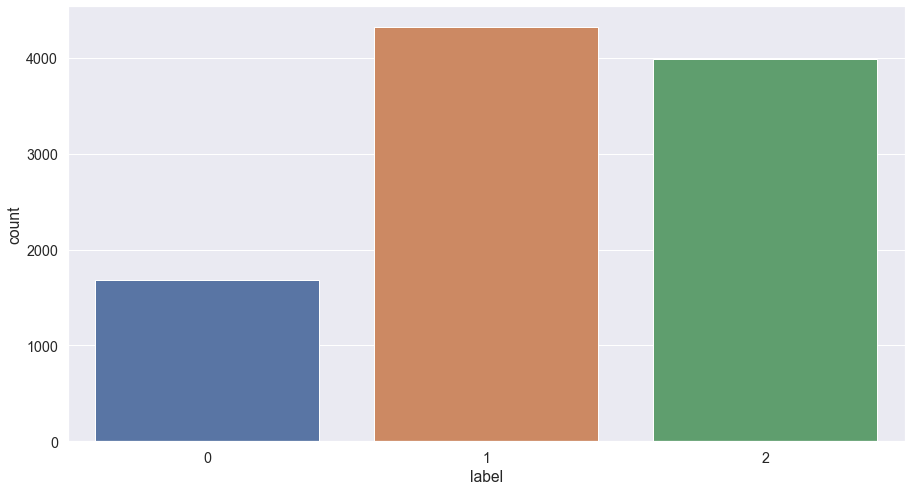

In [5]:
financial_data = financial_data.sample(n=10000)

# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='label', data = financial_data)

In [6]:
# Create training and validation data
# train, test 나누기
x_train, x_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

# Create the data type columns
financial_data.loc[x_train, 'data_type'] = 'train'
financial_data.loc[x_val, 'data_type'] = 'val'

# Vizualiez the number of sentiment occurence on each type of data
financial_data.groupby(['content', 'label', 'data_type']).count()

# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [7]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=3,
                                                          output_attentions=False,
                                                          output_hidden_states=False)

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)

epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    labels_dict = {"neutral":0,"positive":1,"negative":2}
    
    label_dict_inverse = {v: k for k, v in labels_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals



# Model

In [9]:
# 모델
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'Text_summa_반도체_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Epoch 1:  12%|██████▏                                            | 32/266 [05:06<38:50,  9.96s/it, training_loss=0.296]


Epoch 1:  24%|████████████▍                                      | 65/266 [10:23<32:35,  9.73s/it, training_loss=0.325]


Epoch 1:  37%|██████████████████▊                                | 98/266 [15:38<25:58,  9.28s/it, training_loss=0.365]


Epoch 1:  49%|████████████████████████▌                         | 131/266 [20:47<21:40,  9.63s/it, training_loss=0.324]


Epoch 1:  62%|██████████████████████████████▊                   | 164/266 [25:54<15:53,  9.35s/it, training_loss=0.332]


Epoch 1:  74%|█████████████████████████████████████             | 197/266 [31:06<11:00,  9.57s/it, training_loss=0.340]


Epoch 1:  86%|███████████████████████████████████████████▏      | 230/266 [36:17<05:33,  9.25s/it, training_loss=0.316]


Epoch 1:  99%|█████████████████████████████████████████████████▍| 263/266 [41:23<00:27,  9.28s/it, training_loss=0.361]


  0%|                                                                                           | 0/20 [41:49<?, ?it/s]


Epoch 1
Training loss: 1.0471743239944142


  5%|███▉                                                                          | 1/20 [44:10<13:59:28, 2650.97s/it]

Validation loss: 1.017790178035168
F1 Score (Weighted): 0.3839221566338772



Epoch 2:  12%|██████▏                                            | 32/266 [05:04<35:55,  9.21s/it, training_loss=0.334]


Epoch 2:  24%|████████████▍                                      | 65/266 [10:08<31:03,  9.27s/it, training_loss=0.367]


Epoch 2:  37%|██████████████████▊                                | 98/266 [15:12<25:43,  9.19s/it, training_loss=0.368]


Epoch 2:  49%|████████████████████████▌                         | 131/266 [20:17<20:36,  9.16s/it, training_loss=0.316]


Epoch 2:  62%|██████████████████████████████▊                   | 164/266 [25:21<15:39,  9.22s/it, training_loss=0.329]


Epoch 2:  74%|█████████████████████████████████████             | 197/266 [30:27<10:52,  9.46s/it, training_loss=0.344]


Epoch 2:  86%|███████████████████████████████████████████▏      | 230/266 [35:40<05:41,  9.48s/it, training_loss=0.306]


Epoch 2:  99%|█████████████████████████████████████████████████▍| 263/266 [40:57<00:28,  9.63s/it, training_loss=0.378]


  5%|███▊                                                                        | 1/20 [1:25:24<13:59:28, 2650.97s/it]


Epoch 2
Training loss: 1.017085165457618


 10%|███████▌                                                                    | 2/20 [1:27:46<13:09:04, 2630.27s/it]

Validation loss: 1.0111348273906302
F1 Score (Weighted): 0.4147964021001367



Epoch 3:  12%|██████▏                                            | 32/266 [05:06<36:28,  9.35s/it, training_loss=0.348]


Epoch 3:  24%|████████████▍                                      | 65/266 [10:14<31:11,  9.31s/it, training_loss=0.353]


Epoch 3:  37%|██████████████████▊                                | 98/266 [15:24<26:11,  9.36s/it, training_loss=0.310]


Epoch 3:  49%|████████████████████████▌                         | 131/266 [20:38<20:57,  9.32s/it, training_loss=0.301]


Epoch 3:  62%|██████████████████████████████▊                   | 164/266 [25:50<16:04,  9.45s/it, training_loss=0.300]


Epoch 3:  74%|█████████████████████████████████████             | 197/266 [31:00<10:50,  9.42s/it, training_loss=0.312]


Epoch 3:  86%|███████████████████████████████████████████▏      | 230/266 [36:10<05:34,  9.30s/it, training_loss=0.345]


Epoch 3:  99%|█████████████████████████████████████████████████▍| 263/266 [41:18<00:27,  9.30s/it, training_loss=0.305]


 10%|███████▌                                                                    | 2/20 [2:09:21<13:09:04, 2630.27s/it]


Epoch 3
Training loss: 0.9908603611297178


 15%|███████████▍                                                                | 3/20 [2:11:47<12:26:33, 2634.92s/it]

Validation loss: 1.0247596350122006
F1 Score (Weighted): 0.34655722049691684



Epoch 4:  12%|██████▏                                            | 32/266 [05:11<36:02,  9.24s/it, training_loss=0.316]


Epoch 4:  24%|████████████▍                                      | 65/266 [10:22<31:52,  9.51s/it, training_loss=0.321]


Epoch 4:  37%|██████████████████▊                                | 98/266 [15:32<26:29,  9.46s/it, training_loss=0.319]


Epoch 4:  49%|████████████████████████▌                         | 131/266 [20:43<21:00,  9.34s/it, training_loss=0.297]


Epoch 4:  62%|██████████████████████████████▊                   | 164/266 [25:54<15:54,  9.36s/it, training_loss=0.335]


Epoch 4:  74%|█████████████████████████████████████             | 197/266 [31:01<10:40,  9.28s/it, training_loss=0.285]


Epoch 4:  86%|███████████████████████████████████████████▏      | 230/266 [36:10<05:40,  9.46s/it, training_loss=0.270]


Epoch 4:  99%|█████████████████████████████████████████████████▍| 263/266 [41:24<00:28,  9.48s/it, training_loss=0.300]


 15%|███████████▍                                                                | 3/20 [2:53:27<12:26:33, 2634.92s/it]


Epoch 4
Training loss: 0.9438233532403645


 20%|███████████████▏                                                            | 4/20 [2:55:50<11:43:33, 2638.34s/it]

Validation loss: 1.0644576790484976
F1 Score (Weighted): 0.41982586646835784



Epoch 5:  12%|██████▏                                            | 32/266 [05:07<36:33,  9.37s/it, training_loss=0.296]


Epoch 5:  24%|████████████▍                                      | 65/266 [10:16<31:28,  9.40s/it, training_loss=0.267]


Epoch 5:  37%|██████████████████▊                                | 98/266 [15:29<26:09,  9.34s/it, training_loss=0.285]


Epoch 5:  49%|████████████████████████▌                         | 131/266 [20:35<21:02,  9.35s/it, training_loss=0.280]


Epoch 5:  62%|██████████████████████████████▊                   | 164/266 [25:45<15:58,  9.39s/it, training_loss=0.273]


Epoch 5:  74%|█████████████████████████████████████             | 197/266 [30:56<10:40,  9.28s/it, training_loss=0.291]


Epoch 5:  86%|███████████████████████████████████████████▏      | 230/266 [36:02<05:37,  9.38s/it, training_loss=0.262]


Epoch 5:  99%|█████████████████████████████████████████████████▍| 263/266 [41:09<00:27,  9.26s/it, training_loss=0.340]


 20%|███████████████▏                                                            | 4/20 [3:37:16<11:43:33, 2638.34s/it]


Epoch 5
Training loss: 0.8548512357966345


 25%|███████████████████                                                         | 5/20 [3:39:38<10:58:35, 2634.38s/it]

Validation loss: 1.15111043732217
F1 Score (Weighted): 0.39318526487738215



Epoch 6:  12%|██████▏                                            | 32/266 [05:05<36:11,  9.28s/it, training_loss=0.264]


Epoch 6:  24%|████████████▍                                      | 65/266 [10:10<31:11,  9.31s/it, training_loss=0.253]


Epoch 6:  37%|██████████████████▊                                | 98/266 [15:15<25:51,  9.24s/it, training_loss=0.251]


Epoch 6:  49%|████████████████████████▌                         | 131/266 [20:20<20:35,  9.15s/it, training_loss=0.352]


Epoch 6:  62%|██████████████████████████████▊                   | 164/266 [25:25<15:31,  9.13s/it, training_loss=0.215]


Epoch 6:  74%|█████████████████████████████████████             | 197/266 [30:30<10:37,  9.24s/it, training_loss=0.252]


Epoch 6:  86%|███████████████████████████████████████████▏      | 230/266 [35:35<05:34,  9.28s/it, training_loss=0.207]


Epoch 6:  99%|█████████████████████████████████████████████████▍| 263/266 [40:39<00:27,  9.20s/it, training_loss=0.199]


 25%|███████████████████                                                         | 5/20 [4:20:33<10:58:35, 2634.38s/it]


Epoch 6
Training loss: 0.7573699610573905


 30%|██████████████████████▊                                                     | 6/20 [4:22:55<10:11:44, 2621.77s/it]

Validation loss: 1.2726877864370956
F1 Score (Weighted): 0.40711633880761505



Epoch 7:  12%|██████▏                                            | 32/266 [05:04<35:57,  9.22s/it, training_loss=0.230]


Epoch 7:  24%|████████████▍                                      | 65/266 [10:09<30:51,  9.21s/it, training_loss=0.229]


Epoch 7:  37%|██████████████████▊                                | 98/266 [15:13<25:32,  9.12s/it, training_loss=0.224]


Epoch 7:  49%|████████████████████████▌                         | 131/266 [20:18<20:46,  9.23s/it, training_loss=0.180]


Epoch 7:  62%|██████████████████████████████▊                   | 164/266 [25:24<15:43,  9.25s/it, training_loss=0.174]


Epoch 7:  74%|█████████████████████████████████████             | 197/266 [30:27<10:32,  9.16s/it, training_loss=0.252]


Epoch 7:  86%|███████████████████████████████████████████▏      | 230/266 [35:32<05:32,  9.24s/it, training_loss=0.168]


Epoch 7:  99%|█████████████████████████████████████████████████▍| 263/266 [40:36<00:27,  9.23s/it, training_loss=0.288]


 30%|██████████████████████▊                                                     | 6/20 [5:03:48<10:11:44, 2621.77s/it]


Epoch 7
Training loss: 0.6573343768827897


 35%|██████████████████████████▉                                                  | 7/20 [5:06:10<9:26:08, 2612.97s/it]

Validation loss: 1.3491770510977887
F1 Score (Weighted): 0.4023764364240965



Epoch 8:  12%|██████▏                                            | 32/266 [05:05<36:15,  9.30s/it, training_loss=0.224]


Epoch 8:  24%|████████████▍                                      | 65/266 [10:10<30:58,  9.25s/it, training_loss=0.182]


Epoch 8:  37%|██████████████████▊                                | 98/266 [15:16<26:00,  9.29s/it, training_loss=0.180]


Epoch 8:  49%|████████████████████████▌                         | 131/266 [20:21<20:49,  9.26s/it, training_loss=0.231]


Epoch 8:  62%|██████████████████████████████▊                   | 164/266 [25:26<15:44,  9.26s/it, training_loss=0.189]


Epoch 8:  74%|█████████████████████████████████████             | 197/266 [30:32<10:40,  9.28s/it, training_loss=0.208]


Epoch 8:  86%|███████████████████████████████████████████▏      | 230/266 [35:37<05:32,  9.23s/it, training_loss=0.167]


Epoch 8:  99%|█████████████████████████████████████████████████▍| 263/266 [40:42<00:27,  9.26s/it, training_loss=0.203]


 35%|██████████████████████████▉                                                  | 7/20 [5:47:08<9:26:08, 2612.97s/it]


Epoch 8
Training loss: 0.5556955217642892


 40%|██████████████████████████████▊                                              | 8/20 [5:49:30<8:41:45, 2608.82s/it]

Validation loss: 1.518279790878296
F1 Score (Weighted): 0.40333933256426097



Epoch 9:  12%|██████▏                                            | 32/266 [05:04<36:12,  9.28s/it, training_loss=0.155]


Epoch 9:  24%|████████████▍                                      | 65/266 [10:09<30:49,  9.20s/it, training_loss=0.131]


Epoch 9:  37%|██████████████████▊                                | 98/266 [15:14<25:55,  9.26s/it, training_loss=0.197]


Epoch 9:  49%|████████████████████████▌                         | 131/266 [20:18<20:41,  9.20s/it, training_loss=0.156]


Epoch 9:  62%|██████████████████████████████▊                   | 164/266 [25:23<15:40,  9.22s/it, training_loss=0.209]


Epoch 9:  74%|█████████████████████████████████████             | 197/266 [30:28<10:37,  9.23s/it, training_loss=0.152]


Epoch 9:  86%|███████████████████████████████████████████▏      | 230/266 [35:33<05:34,  9.28s/it, training_loss=0.140]


Epoch 9:  99%|█████████████████████████████████████████████████▍| 263/266 [40:38<00:27,  9.24s/it, training_loss=0.184]


 40%|██████████████████████████████▊                                              | 8/20 [6:30:24<8:41:45, 2608.82s/it]


Epoch 9
Training loss: 0.4738869469864924


 45%|██████████████████████████████████▋                                          | 9/20 [6:32:45<7:57:31, 2604.70s/it]

Validation loss: 1.622387466278482
F1 Score (Weighted): 0.3846586369330074



Epoch 10:  12%|██████                                            | 32/266 [04:56<32:32,  8.34s/it, training_loss=0.108]


Epoch 10:  24%|████████████▏                                     | 65/266 [09:31<27:40,  8.26s/it, training_loss=0.109]


Epoch 10:  37%|██████████████████▍                               | 98/266 [14:10<24:35,  8.78s/it, training_loss=0.141]


Epoch 10:  49%|████████████████████████▏                        | 131/266 [19:04<19:58,  8.88s/it, training_loss=0.098]


Epoch 10:  62%|██████████████████████████████▏                  | 164/266 [23:58<15:04,  8.87s/it, training_loss=0.146]


Epoch 10:  74%|████████████████████████████████████▎            | 197/266 [28:52<10:11,  8.86s/it, training_loss=0.207]


Epoch 10:  86%|██████████████████████████████████████████▎      | 230/266 [33:46<05:19,  8.88s/it, training_loss=0.125]


Epoch 10:  99%|████████████████████████████████████████████████▍| 263/266 [38:40<00:26,  8.95s/it, training_loss=0.143]


 45%|██████████████████████████████████▋                                          | 9/20 [7:11:41<7:57:31, 2604.70s/it]


Epoch 10
Training loss: 0.39828588583863767


 50%|██████████████████████████████████████                                      | 10/20 [7:13:57<7:07:15, 2563.56s/it]

Validation loss: 1.745675041320476
F1 Score (Weighted): 0.40517685275049675



Epoch 11:  12%|██████                                            | 32/266 [04:52<34:30,  8.85s/it, training_loss=0.098]


Epoch 11:  24%|████████████▏                                     | 65/266 [09:46<29:50,  8.91s/it, training_loss=0.071]


Epoch 11:  37%|██████████████████▍                               | 98/266 [14:39<24:59,  8.93s/it, training_loss=0.072]


Epoch 11:  49%|████████████████████████▏                        | 131/266 [19:33<20:02,  8.91s/it, training_loss=0.119]


Epoch 11:  62%|██████████████████████████████▏                  | 164/266 [24:27<15:09,  8.91s/it, training_loss=0.081]


Epoch 11:  74%|████████████████████████████████████▎            | 197/266 [29:21<10:08,  8.81s/it, training_loss=0.113]


Epoch 11:  86%|██████████████████████████████████████████▎      | 230/266 [34:15<05:21,  8.93s/it, training_loss=0.075]


Epoch 11:  99%|████████████████████████████████████████████████▍| 263/266 [39:09<00:26,  8.87s/it, training_loss=0.116]


 50%|██████████████████████████████████████                                      | 10/20 [7:53:21<7:07:15, 2563.56s/it]


Epoch 11
Training loss: 0.3311167652333589


 55%|█████████████████████████████████████████▊                                  | 11/20 [7:55:38<6:21:39, 2544.34s/it]

Validation loss: 1.8241203287814527
F1 Score (Weighted): 0.4019408375695957



Epoch 12:  12%|██████                                            | 32/266 [04:54<34:38,  8.88s/it, training_loss=0.117]


Epoch 12:  24%|████████████▏                                     | 65/266 [09:47<29:45,  8.88s/it, training_loss=0.185]


Epoch 12:  37%|██████████████████▍                               | 98/266 [14:41<24:54,  8.89s/it, training_loss=0.072]


Epoch 12:  49%|████████████████████████▏                        | 131/266 [19:35<20:07,  8.94s/it, training_loss=0.097]


Epoch 12:  62%|██████████████████████████████▏                  | 164/266 [24:29<15:03,  8.86s/it, training_loss=0.079]


Epoch 12:  74%|████████████████████████████████████▎            | 197/266 [29:24<10:14,  8.91s/it, training_loss=0.129]


Epoch 12:  86%|██████████████████████████████████████████▎      | 230/266 [34:17<05:17,  8.83s/it, training_loss=0.092]


Epoch 12:  99%|████████████████████████████████████████████████▍| 263/266 [39:12<00:26,  8.93s/it, training_loss=0.084]


 55%|█████████████████████████████████████████▊                                  | 11/20 [8:35:05<6:21:39, 2544.34s/it]


Epoch 12
Training loss: 0.28496154537774565


 60%|█████████████████████████████████████████████▌                              | 12/20 [8:37:21<5:37:35, 2531.97s/it]

Validation loss: 1.9523700171328606
F1 Score (Weighted): 0.4086544679808948



Epoch 13:  12%|██████                                            | 32/266 [04:52<34:22,  8.81s/it, training_loss=0.048]


Epoch 13:  24%|████████████▏                                     | 65/266 [09:46<29:55,  8.93s/it, training_loss=0.022]


Epoch 13:  37%|██████████████████▍                               | 98/266 [14:39<24:51,  8.88s/it, training_loss=0.081]


Epoch 13:  49%|████████████████████████▏                        | 131/266 [19:33<20:07,  8.94s/it, training_loss=0.086]


Epoch 13:  62%|██████████████████████████████▏                  | 164/266 [24:27<15:10,  8.92s/it, training_loss=0.036]


Epoch 13:  74%|████████████████████████████████████▎            | 197/266 [29:21<10:15,  8.92s/it, training_loss=0.162]


Epoch 13:  86%|██████████████████████████████████████████▎      | 230/266 [34:14<05:21,  8.93s/it, training_loss=0.089]


Epoch 13:  99%|████████████████████████████████████████████████▍| 263/266 [39:08<00:26,  8.85s/it, training_loss=0.078]


 60%|█████████████████████████████████████████████▌                              | 12/20 [9:16:45<5:37:35, 2531.97s/it]


Epoch 13
Training loss: 0.24405356362125927


 65%|█████████████████████████████████████████████████▍                          | 13/20 [9:19:01<4:54:14, 2522.14s/it]

Validation loss: 2.00595559718761
F1 Score (Weighted): 0.4042783421668625



Epoch 14:  12%|██████                                            | 32/266 [04:53<34:35,  8.87s/it, training_loss=0.073]


Epoch 14:  24%|████████████▏                                     | 65/266 [09:46<29:45,  8.88s/it, training_loss=0.090]


Epoch 14:  37%|██████████████████▍                               | 98/266 [14:39<24:53,  8.89s/it, training_loss=0.038]


Epoch 14:  49%|████████████████████████▏                        | 131/266 [19:35<20:03,  8.91s/it, training_loss=0.134]


Epoch 14:  62%|██████████████████████████████▏                  | 164/266 [24:32<15:04,  8.87s/it, training_loss=0.071]


Epoch 14:  74%|████████████████████████████████████▎            | 197/266 [29:26<10:13,  8.89s/it, training_loss=0.149]


Epoch 14:  86%|██████████████████████████████████████████▎      | 230/266 [34:20<05:21,  8.93s/it, training_loss=0.109]


Epoch 14:  99%|████████████████████████████████████████████████▍| 263/266 [39:13<00:26,  8.92s/it, training_loss=0.066]


 65%|█████████████████████████████████████████████████▍                          | 13/20 [9:58:30<4:54:14, 2522.14s/it]


Epoch 14
Training loss: 0.20207860521075868


 70%|████████████████████████████████████████████████████▌                      | 14/20 [10:00:46<4:11:42, 2517.00s/it]

Validation loss: 2.153641530807982
F1 Score (Weighted): 0.40883793421410286



Epoch 15:  12%|██████                                            | 32/266 [04:53<34:27,  8.83s/it, training_loss=0.033]


Epoch 15:  24%|████████████▏                                     | 65/266 [09:46<29:44,  8.88s/it, training_loss=0.056]


Epoch 15:  37%|██████████████████▍                               | 98/266 [14:39<24:45,  8.84s/it, training_loss=0.094]


Epoch 15:  49%|████████████████████████▏                        | 131/266 [19:31<19:53,  8.84s/it, training_loss=0.041]


Epoch 15:  62%|██████████████████████████████▏                  | 164/266 [24:25<15:08,  8.91s/it, training_loss=0.124]


Epoch 15:  74%|████████████████████████████████████▎            | 197/266 [29:18<10:11,  8.87s/it, training_loss=0.090]


Epoch 15:  86%|██████████████████████████████████████████▎      | 230/266 [34:11<05:20,  8.90s/it, training_loss=0.048]


Epoch 15:  99%|████████████████████████████████████████████████▍| 263/266 [39:04<00:26,  8.88s/it, training_loss=0.076]


 70%|████████████████████████████████████████████████████▌                      | 14/20 [10:40:07<4:11:42, 2517.00s/it]


Epoch 15
Training loss: 0.18122198459293162


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [10:42:23<3:29:14, 2510.87s/it]

Validation loss: 2.1928918310936463
F1 Score (Weighted): 0.40634458261844564



Epoch 16:  12%|██████                                            | 32/266 [04:53<34:51,  8.94s/it, training_loss=0.073]


Epoch 16:  24%|████████████▏                                     | 65/266 [09:45<29:54,  8.93s/it, training_loss=0.101]


Epoch 16:  37%|██████████████████▍                               | 98/266 [14:39<25:02,  8.94s/it, training_loss=0.031]


Epoch 16:  49%|████████████████████████▏                        | 131/266 [19:33<20:02,  8.90s/it, training_loss=0.074]


Epoch 16:  62%|██████████████████████████████▏                  | 164/266 [24:27<15:09,  8.92s/it, training_loss=0.052]


Epoch 16:  74%|████████████████████████████████████▎            | 197/266 [29:21<10:14,  8.90s/it, training_loss=0.040]


Epoch 16:  86%|██████████████████████████████████████████▎      | 230/266 [34:13<05:21,  8.92s/it, training_loss=0.031]


Epoch 16:  99%|████████████████████████████████████████████████▍| 263/266 [39:07<00:26,  8.86s/it, training_loss=0.040]


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [11:21:46<3:29:14, 2510.87s/it]


Epoch 16
Training loss: 0.1591653509233567


 80%|████████████████████████████████████████████████████████████               | 16/20 [11:24:02<2:47:09, 2507.42s/it]

Validation loss: 2.2636819976441402
F1 Score (Weighted): 0.40274914169887216



Epoch 17:  12%|██████                                            | 32/266 [04:53<34:39,  8.89s/it, training_loss=0.107]


Epoch 17:  24%|████████████▏                                     | 65/266 [09:48<29:56,  8.94s/it, training_loss=0.035]


Epoch 17:  37%|██████████████████▍                               | 98/266 [14:41<24:46,  8.85s/it, training_loss=0.017]


Epoch 17:  49%|████████████████████████▏                        | 131/266 [19:35<20:01,  8.90s/it, training_loss=0.038]


Epoch 17:  62%|██████████████████████████████▏                  | 164/266 [24:29<15:13,  8.95s/it, training_loss=0.031]


Epoch 17:  74%|████████████████████████████████████▎            | 197/266 [29:23<10:15,  8.92s/it, training_loss=0.017]


Epoch 17:  86%|██████████████████████████████████████████▎      | 230/266 [34:17<05:19,  8.87s/it, training_loss=0.061]


Epoch 17:  99%|████████████████████████████████████████████████▍| 263/266 [39:10<00:26,  8.93s/it, training_loss=0.065]


 80%|████████████████████████████████████████████████████████████               | 16/20 [12:03:28<2:47:09, 2507.42s/it]


Epoch 17
Training loss: 0.14224246076371214


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [12:05:44<2:05:17, 2505.87s/it]

Validation loss: 2.3835362272059664
F1 Score (Weighted): 0.39820607189543283



Epoch 18:  12%|██████                                            | 32/266 [04:53<34:35,  8.87s/it, training_loss=0.057]


Epoch 18:  24%|████████████▏                                     | 65/266 [09:45<29:46,  8.89s/it, training_loss=0.049]


Epoch 18:  37%|██████████████████▍                               | 98/266 [14:39<25:01,  8.94s/it, training_loss=0.023]


Epoch 18:  49%|████████████████████████▏                        | 131/266 [19:32<19:51,  8.83s/it, training_loss=0.077]


Epoch 18:  62%|██████████████████████████████▏                  | 164/266 [24:25<15:03,  8.86s/it, training_loss=0.101]


Epoch 18:  74%|████████████████████████████████████▎            | 197/266 [29:19<10:12,  8.88s/it, training_loss=0.032]


Epoch 18:  86%|██████████████████████████████████████████▎      | 230/266 [34:13<05:22,  8.95s/it, training_loss=0.069]


Epoch 18:  99%|████████████████████████████████████████████████▍| 263/266 [39:07<00:26,  8.97s/it, training_loss=0.037]


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [12:45:08<2:05:17, 2505.87s/it]


Epoch 18
Training loss: 0.1303670376091075


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [12:47:23<1:23:27, 2503.81s/it]

Validation loss: 2.412896458138811
F1 Score (Weighted): 0.3950968372619355



Epoch 19:  12%|██████                                            | 32/266 [04:52<34:40,  8.89s/it, training_loss=0.071]


Epoch 19:  24%|████████████▏                                     | 65/266 [09:45<29:31,  8.81s/it, training_loss=0.041]


Epoch 19:  37%|██████████████████▍                               | 98/266 [14:39<24:51,  8.88s/it, training_loss=0.035]


Epoch 19:  49%|████████████████████████▏                        | 131/266 [19:31<19:59,  8.89s/it, training_loss=0.020]


Epoch 19:  62%|██████████████████████████████▏                  | 164/266 [24:25<15:08,  8.91s/it, training_loss=0.032]


Epoch 19:  74%|████████████████████████████████████▎            | 197/266 [29:18<10:13,  8.89s/it, training_loss=0.025]


Epoch 19:  86%|██████████████████████████████████████████▎      | 230/266 [34:12<05:20,  8.90s/it, training_loss=0.093]


Epoch 19:  99%|████████████████████████████████████████████████▍| 263/266 [39:05<00:26,  8.85s/it, training_loss=0.082]


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [13:26:44<1:23:27, 2503.81s/it]


Epoch 19
Training loss: 0.12279256388432998


 95%|█████████████████████████████████████████████████████████████████████████▏   | 19/20 [13:29:00<41:41, 2501.65s/it]

Validation loss: 2.4226262518700135
F1 Score (Weighted): 0.3967938634864932



Epoch 20:  12%|██████                                            | 32/266 [04:53<34:31,  8.85s/it, training_loss=0.015]


Epoch 20:  24%|████████████▏                                     | 65/266 [09:46<30:02,  8.97s/it, training_loss=0.080]


Epoch 20:  37%|██████████████████▍                               | 98/266 [14:40<24:49,  8.87s/it, training_loss=0.011]


Epoch 20:  49%|████████████████████████▏                        | 131/266 [19:34<20:16,  9.01s/it, training_loss=0.013]


Epoch 20:  62%|██████████████████████████████▏                  | 164/266 [24:29<15:08,  8.91s/it, training_loss=0.048]


Epoch 20:  74%|████████████████████████████████████▎            | 197/266 [29:23<10:16,  8.94s/it, training_loss=0.057]


Epoch 20:  86%|██████████████████████████████████████████▎      | 230/266 [34:17<05:22,  8.96s/it, training_loss=0.074]


Epoch 20:  99%|████████████████████████████████████████████████▍| 263/266 [39:11<00:26,  8.86s/it, training_loss=0.045]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 19/20 [14:08:27<41:41, 2501.65s/it]


Epoch 20
Training loss: 0.11495550820617971


100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [14:10:43<00:00, 2552.17s/it]

Validation loss: 2.422355849692162
F1 Score (Weighted): 0.3978898204793903


# Test

In [18]:
# Load the best model & Make Predictions

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=3,
                                                          output_attentions=False,
                                                          output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('Text_summa_반도체_finBERT_epoch_20.model', 
                                 map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy: 43/252

Class: positive
Accuracy: 308/649

Class: negative
Accuracy: 251/599



In [10]:
val_f1

0.3978898204793903

In [11]:
val_loss

2.422355849692162

In [19]:
preds = predictions
labels = true_vals

labels_dict = {"neutral":0,"positive":1,"nagative":2}

label_dict_inverse = {v: k for k, v in labels_dict.items()}

preds_flat = np.argmax(preds, axis=1).flatten()
labels_flat = labels.flatten()
    
for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
# 점수 산정 부분
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('acc', accuracy_score(labels_flat, preds_flat))
print('precision', precision_score(labels_flat, preds_flat,average='macro'))
print('recall', recall_score(labels_flat, preds_flat,average='macro'))
print('f1', f1_score(labels_flat, preds_flat,average='macro'))


Class: neutral
Accuracy: 43/252

Class: positive
Accuracy: 308/649

Class: nagative
Accuracy: 251/599

acc 0.4013333333333333
precision 0.3564033920988053
recall 0.35474763711797186
f1 0.35493523811646366


In [20]:
result_data = pd.read_csv('./text_summa_0422.csv', index_col=0)
result_data

# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    result_data.content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']



dataset_val = TensorDataset(input_ids_train, attention_masks_train)


# 요부분 빠졌더라
batch_size = 5

# dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

result_d = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

model.eval()
result = []
for batch in result_d:

    batch = tuple(b.to(device) for b in batch)

    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1],
#               'labels':         batch[2],
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    print(outputs)
    result.append(outputs)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


SequenceClassifierOutput(loss=None, logits=tensor([[-3.2687,  1.1299,  3.0143],
        [-2.9736,  1.1587,  2.5696],
        [-3.7328,  1.0486,  3.4666],
        [-2.3551, -1.7083,  4.4317],
        [-1.9756,  3.7996, -1.8439]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[ 2.0241, -3.4690,  1.6476],
        [-4.0024,  3.8080,  0.9436],
        [-0.0913,  0.3269,  0.2974],
        [-0.4560, -1.6870,  2.0699],
        [ 0.4913, -1.8649,  1.4830]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-3.8884,  3.1260,  1.2797],
        [-3.7601,  3.5309,  0.5002],
        [-2.4947,  2.1302,  0.5475],
        [-2.8201, -0.6114,  4.2325],
        [-3.3031,  0.1170,  3.8758]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-0.0913,  0.3269,  0.2974],
        [-3.3753,  4.1840, -0.4720],
        [-2.9116,  0.9866,  2.5441],
        [ 2.4502, -2.8647, -0.3461],
        

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0913,  0.3269,  0.2974],
        [ 0.1770, -1.9088,  1.6687],
        [-3.6312,  2.1604,  1.9919],
        [-4.0235,  2.4591,  2.1705],
        [-3.8408,  3.2806,  1.3892]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-3.4982,  4.2844, -0.5998],
        [-1.5734, -2.7452,  4.5735],
        [-3.3628,  0.8311,  2.8836],
        [-3.5466,  2.5392,  1.9714],
        [-2.0180,  0.6342,  2.4621]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[ 1.4358, -0.6951, -1.3599],
        [-1.4542,  2.8053, -1.8539],
        [-3.6470,  1.3365,  3.1460],
        [ 2.4878, -2.4030, -0.0578],
        [-1.6113, -0.6485,  2.9929]]), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-3.6627,  3.2268,  1.3232],
        [-1.2560, -0.1813,  1.7392],
        [-3.1202, -0.8116,  4.5560],
        [-3.6648,  4.2501, -0.3354],
        

In [27]:
result_lst=[]
for t in result:
    for tmp in t['logits']:
        result_lst.append(tmp.argmax().item())

result_ser = pd.Series(result_lst)

status = ['Neutral', 'Positive', 'Negative']
daily_states = result_ser.value_counts().head(1).index[0]
print('Daily Stock Status:', status[daily_states])

keydf = pd.read_csv('./keyword_0422.csv')
keywords = []
for status in range(3):
    ind = result_ser[result_ser.values == 0].sample(5).index.tolist()
    keyword = []
    for li in keydf.iloc[ind]['keywords'].apply(lambda x : x.strip('[]').split(',')[:5]).values:
        for word in li:
            keyword.append(word.strip('" ').strip("' "))
    keywords.append(keyword)

Daily Stock Status: Negative


In [31]:
import matplotlib.pyplot as plt
from PIL import Image

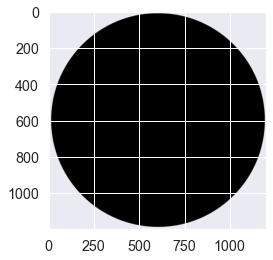

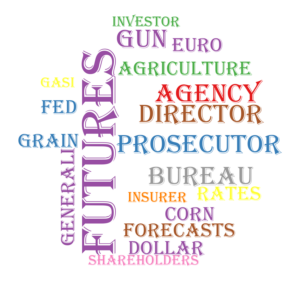

In [34]:
from wordcloud import WordCloud
from collections import Counter
font_path = 'C:\Windows\Fonts\ALGER.TTF'

cm = ['Set1','Set2','Set3']

icon = Image.open('./sss.png')    # 마스크가 될 이미지 불러오기 
plt.imshow(icon)

# palettes = 'Dark2'
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

wordcloud = WordCloud(
    font_path = font_path,
    width = 1000,
    height= 1000,
    background_color= 'white',
    colormap=cm[0],
    mask=mask
)
count = Counter(keywords[0])
wordcloud = wordcloud.generate_from_frequencies(count)

def __array__(self):
    return self.to_array()

def to_array(self):
    return np.array(self.to_image())

array = wordcloud.to_array()
plt.figure(figsize=(5,15))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
font_path = 'C:\Windows\Fonts\ALGER.TTF'

cm = ['Set1','Accent','Dark2']

icon = Image.open('./ss.png')    # 마스크가 될 이미지 불러오기 
# plt.imshow(icon)

# palettes = 'Dark2'
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

wordcloud = WordCloud(
    font_path = font_path,
    width = 1000,
    height= 1000,
    background_color= 'white',
    colormap=cm[2],
    mask=mask
)
count = Counter(keywords[2])
wordcloud = wordcloud.generate_from_frequencies(count)

def __array__(self):
    return self.to_array()

def to_array(self):
    return np.array(self.to_image())

array = wordcloud.to_array()
plt.figure(figsize=(5,15))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()